In [3]:

import sys
import pathlib
import numpy as np
import sklearn
from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras.losses import kl_divergence
from tensorflow.keras.initializers import RandomNormal, GlorotUniform
from tensorflow.keras.optimizers import SGD, Adam

import umap
import hdbscan
from mdutils.mdutils import MdUtils

FLP_path = pathlib.Path('/home/relogu/Desktop/OneDrive/UNIBO/Magistrale/Federated Learning Project').absolute()
sys.path.insert(1, str(FLP_path))

from py.losses import get_keras_loss
from py.dec.util import create_denoising_autoencoder, create_clustering_model, target_distribution
import py.metrics as my_metrics
from py.util import compute_centroid_np, get_dims_from_weights

results_path = pathlib.Path('/home/relogu/Desktop/OneDrive/UNIBO/Magistrale/Federated Learning Project/output_dec_bmnist')
N_CLUSTERS = 10
LOSS = 'bce'

gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus, 'GPU')
# disable possible gpu devices for this kernel
tf.config.set_visible_devices([], 'GPU')

In [4]:
# prefix = 'aggregated_weights_'
encoder_param = np.load(results_path/str('encoder.npz'),
                        allow_pickle=True)
encoder_param = np.squeeze(np.array([encoder_param[p] for p in encoder_param]))
encoder_ft_param = np.load(results_path/str('encoder_ft.npz'),
                           allow_pickle=True)
encoder_ft_param = np.squeeze(np.array([encoder_ft_param[p] for p in encoder_ft_param]))
encoder_final_param = np.load(results_path/str('encoder_final.npz'),
                              allow_pickle=True)
encoder_final_param = np.squeeze(np.array([encoder_final_param[p] for p in encoder_final_param]))
initial_centroids = np.load(results_path/'initial_centroids.npz',
                            allow_pickle=True)
initial_centroids = np.array([initial_centroids[p] for p in initial_centroids])
final_centroids = np.load(results_path/str('final_centroids.npz'),
                          allow_pickle=True)
final_centroids = np.array([final_centroids[p] for p in final_centroids])

In [ ]:
print('Initial Centroids: {}'.format(initial_centroids))
print('Final Centroids: {}'.format(final_centroids))
delta_centroids = final_centroids-initial_centroids
print('Delta Centroids: {}'.format(delta_centroids))

In [5]:
# preparing dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
n_features = int(x_train.shape[1]*x_train.shape[1])
x_train, x_test = np.round(x_train.reshape(x_train.shape[0], n_features)/255), np.round(x_test.reshape(x_test.shape[0], n_features)/255)

In [11]:
# setting up the autoencoder
dims = get_dims_from_weights(encoder_param)
config = {
    'batch_size': 256,
    'n_clusters': 10,
    'kmeans_n_init': 20,
    'ae_epochs': 50000,
    'ae_optimizer': SGD(
        learning_rate=0.1,
        momentum=0.9,
        decay=(0.1-0.0001)/50000),
    # 'ae_optimizer': Adam(),
    'ae_dims': dims,
    'ae_act': 'relu',
    # 'ae_init': RandomNormal(mean=0.0,
    #                         stddev=0.01),
    'ae_init': GlorotUniform(seed=51550),
    'is_tied': True,
    'u_norm_reg': False,
    'ortho_w_con': False,
    'uncoll_feat_reg': False,
    'use_bias': True,
    'dropout_rate': 0.0,
    'noise_rate': 0.0,
    'ran_flip_conf': None,
    'ae_metrics': [
        my_metrics.rounded_accuracy,
    ],
    'cl_optimizer': SGD(
        learning_rate=0.01,
        momentum=0.9),
    'update_interval': 160,
    'ae_loss': get_keras_loss(LOSS),
    'cl_loss': 'kld',
    'seed': 51550}

autoencoder, encoder, decoder = create_denoising_autoencoder(
    flavor='real',
    dims=config['ae_dims'],
    activation=config['ae_act'],
    w_init=config['ae_init'],
    is_tied=config['is_tied'],
    u_norm_reg=config['u_norm_reg'],
    ortho_w_con=config['ortho_w_con'],
    uncoll_feat_reg=config['uncoll_feat_reg'],
    use_bias=config['use_bias'],
    dropout_rate=config['dropout_rate'],
    noise_rate=config['noise_rate'],
    ran_flip_conf=None,
    )

autoencoder.compile(
    metrics=config['ae_metrics'],
    optimizer=config['ae_optimizer'],
    loss=config['ae_loss']
)
# initializing clustering model
clustering_model = create_clustering_model(
    N_CLUSTERS,
    encoder)
# compiling the clustering model (necessary for evaluating)
clustering_model.compile(
    loss='kld')

In [ ]:
encoder.set_weights(encoder_ft_param)
z = encoder(x_train).numpy()
encoder.set_weights(encoder_final_param)
clustering_model.get_layer(
    name='clustering').set_weights([final_centroids])
y_pred = clustering_model(x_train).numpy().argmax(1)

tsne = TSNE(
    n_components=2,
    random_state=51550,
    n_jobs=-1,
    #verbose=10
    ).fit_transform(z)
print('tsne done')
dbcl_tsne = DBSCAN(
    min_samples=40,
    eps=3,
    n_jobs=-1,
    #verbose=10
    ).fit(tsne)
print('dbscan1 done')
dbcl = DBSCAN(
    #min_samples=5,
    eps=35,
    n_jobs=-1,
    #verbose=10
    ).fit(z)
print('dbscan2 done')
N_CLUSTERS = 10
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    #verbose=10
    ).fit(z)
print('kmeans done')
print('Accuracies obtained (HDP as ground-truth, 6+1 labels)')
labels_list = [dbcl_tsne.labels_, y_pred, dbcl.labels_, kmeans.labels_, y_train]
descs_list = ['dbscan_tsne', 'dec', 'dbscan', 'kmeans', 'ground_truth']
for labels, desc in zip(labels_list[:-1], descs_list[:-1]):
    n_classes = len(np.unique(labels))
    if n_classes > 1:
        accuracy = my_metrics.acc(y_train, labels)
        s_accuracy = (n_classes/(n_classes-1))*accuracy-(1/(n_classes-1))
        nmi_score = my_metrics.nmi(y_train, labels)
        print('\t{}: acc {}, s_acc {}, nmi {}, {} labels'. \
            format(desc, accuracy, s_accuracy, nmi_score, n_classes))

In [1]:
## some final stats
encoder.set_weights(encoder_final_param)
clustering_model.get_layer(
    name='clustering').set_weights([final_centroids])

feat_test = encoder(x_test)
# computations to see the effective retro-projecting capability of DEC
loss = autoencoder.evaluate(x_test, x_test, verbose=0)
x_ae_test = autoencoder(x_test)
y_pred = clustering_model.predict(x_test, verbose=0).argmax(1)
y_ae_pred = clustering_model.predict(np.round(x_ae_test), verbose=0).argmax(1)
print('Final cycle accuracy is {}\nFinal accuracy is {}\n{} loss is {}'. \
    format(my_metrics.acc(y_pred, y_ae_pred), my_metrics.acc(y_pred, y_test), LOSS, loss))

confusion_matrix = sklearn.metrics.confusion_matrix(y_pred, y_ae_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('Cycle Predicted Label', fontsize=25)
plt.savefig(results_path/'conf_matrix_cycle_accuracy.png')
plt.close()

confusion_matrix = sklearn.metrics.confusion_matrix(y_pred, y_test)
plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('True Label', fontsize=25)
plt.savefig(results_path/'conf_matrix_accuracy.png')
plt.close()

feat_centroids = np.array(clustering_model.get_layer(name='clustering').get_weights())[0]

NameError: name 'clustering_model' is not defined

2021-11-13 16:21:01.543747: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.
2021-11-13 16:21:04.990120: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.
2021-11-13 16:21:05.068131: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 120000000 exceeds 10% of free system memory.
2021-11-13 16:21:05.160278: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 120000000 exceeds 10% of free system memory.
2021-11-13 16:21:05.184484: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 120000000 exceeds 10% of free system memory.


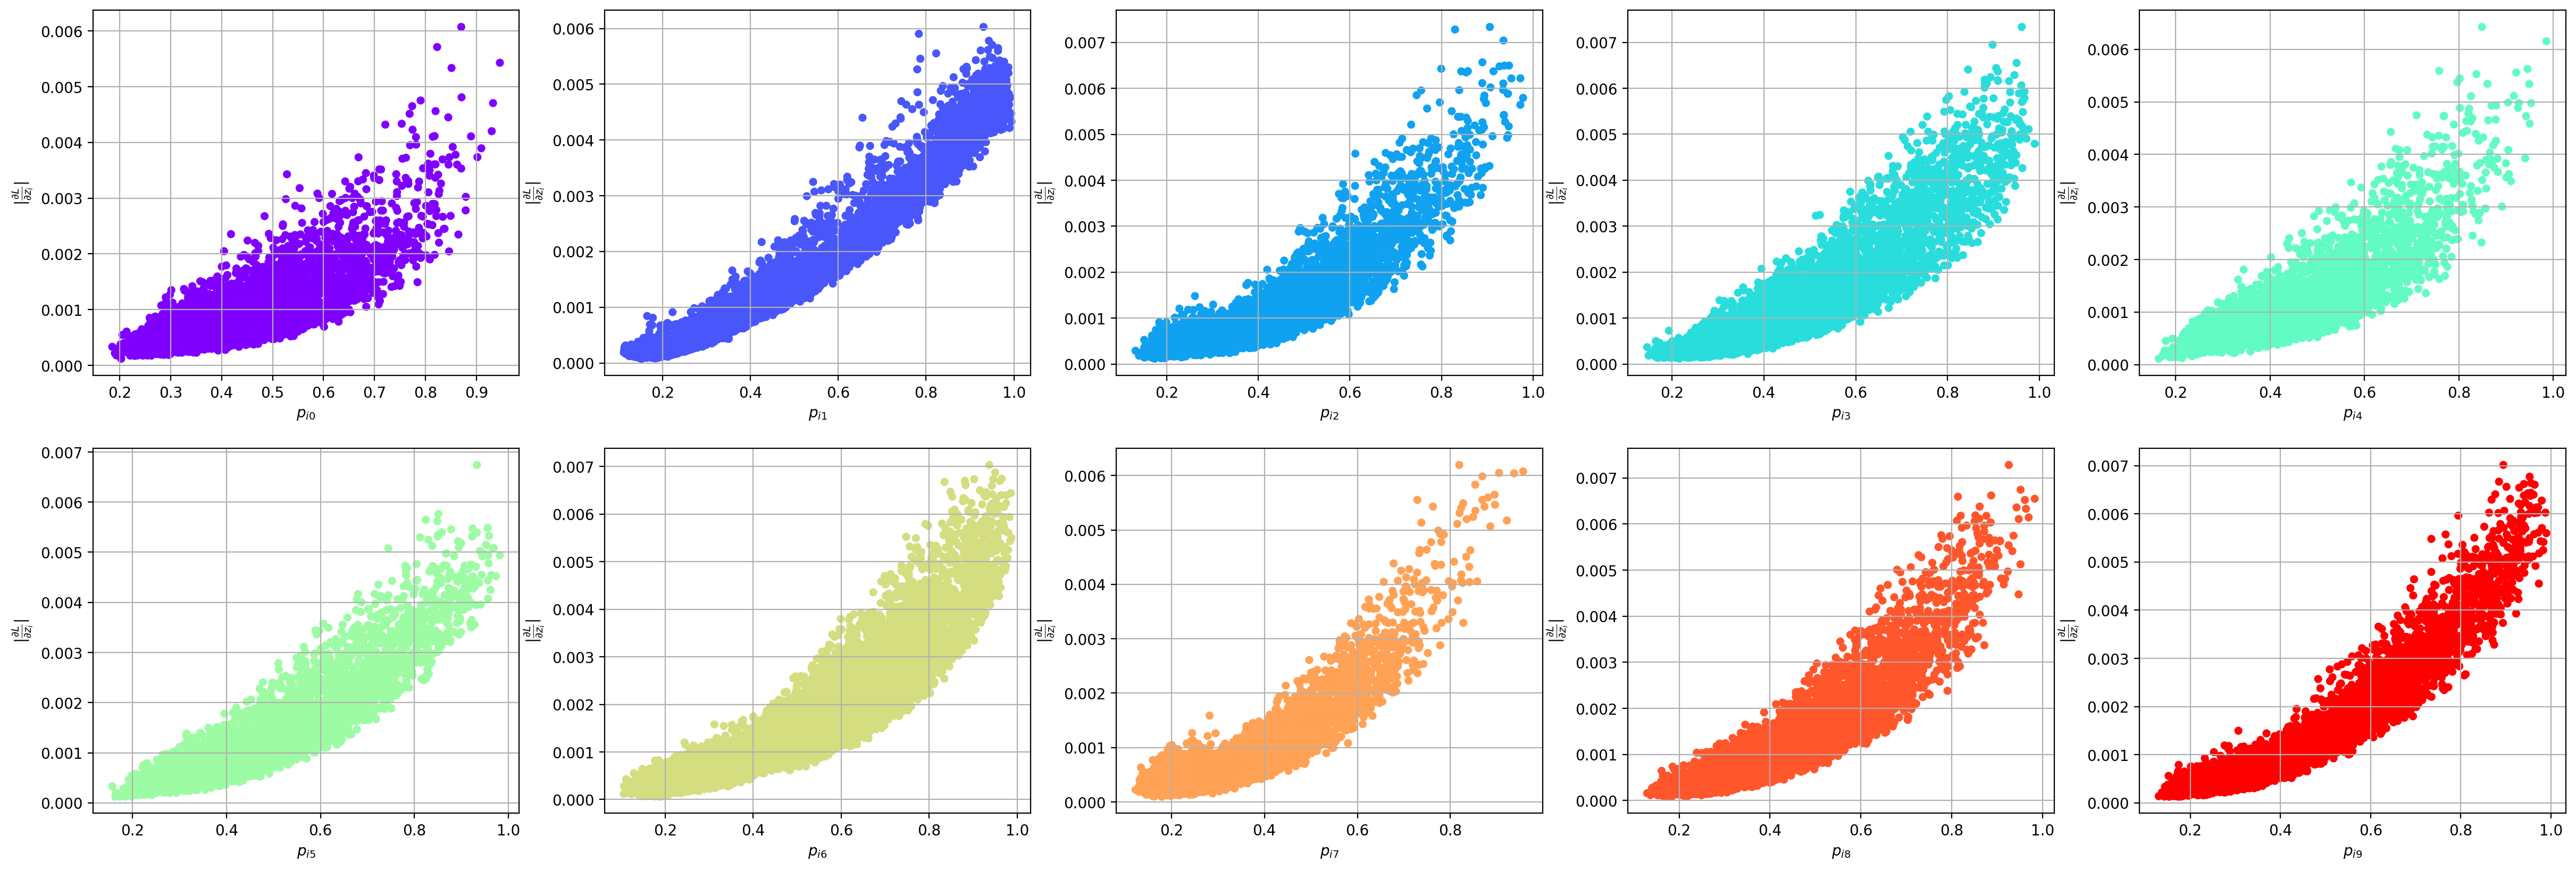

In [12]:
## Gradients plot
# set weights
encoder.set_weights(encoder_ft_param)
# initializing clustering model
clustering_model = create_clustering_model(
    n_clusters=N_CLUSTERS,
    alpha=9,
    encoder=encoder)
# compiling the clustering model (necessary for evaluating)
clustering_model.compile(
    loss='kld')
clustering_model.get_layer(
    name='clustering').set_weights([initial_centroids])
cl_layer = clustering_model.get_layer(name='clustering')
# get soft assignments
q = clustering_model(x_train).numpy()
p = target_distribution(q)
initial_pred = q.argmax(1)

# compute gradients
z = encoder(x_train).numpy()
qq = (q.T/q.sum(axis=1)).T
pp = (qq**2)
pp = (pp.T/pp.sum(axis=1)).T
grad = 2.0/(1.0+cdist(z, initial_centroids, 'sqeuclidean'))*(pp-qq)*cdist(z, initial_centroids, 'cityblock')

fig, axs = plt.subplots(2, int(N_CLUSTERS/2),
                        figsize=(30, 10),
                        squeeze=True,
                        facecolor='white',
                        dpi=200)
k=0
ind = np.bincount(q.argmax(axis=1)).argmin()
colors = cm.rainbow(np.linspace(0, 1, N_CLUSTERS))
for i in range(2):
    for j in range(int(N_CLUSTERS/2)):
        idx = (initial_pred == k)
        ax = axs[i, j]
        scatter = ax.scatter(qq[idx, ind],
                             grad[idx, ind],
                             color=colors[k],
                             s=[20]*len(p[idx, k]),
                             )
        ax.set_xlabel(r'$p_{i%d}$' % k)
        ax.set_ylabel(r'$|\frac{\partial L}{\partial z_i}|$')
        ax.grid()
        k+=1
        
        
datapoints = tf.Variable(x_train, dtype=tf.float32)
soft_assignments = tf.Variable(p)

with tf.GradientTape() as tape:
    embedded_points = encoder(datapoints)
    outputs = cl_layer(embedded_points)
    kld = kl_divergence(soft_assignments, outputs)
    dc_da = tape.gradient(kld, embedded_points)

norm_dc_da = np.linalg.norm(dc_da, axis=1)
    
fig, axs = plt.subplots(2, int(N_CLUSTERS/2),
                        figsize=(30, 10),
                        squeeze=True,
                        facecolor='white',
                        dpi=200)
k=0
colors = cm.rainbow(np.linspace(0, 1, N_CLUSTERS))
for i in range(2):
    for j in range(int(N_CLUSTERS/2)):
        idx = (initial_pred == k)
        ax = axs[i, j]
        scatter = ax.scatter(p[idx, k],
                             norm_dc_da[idx],
                             color=colors[k],
                             s=[20]*len(p[idx, k]),
                             )
        ax.set_xlabel(r'$p_{i%d}$' % k)
        ax.set_ylabel(r'$|\frac{\partial L}{\partial z_i}|$')
        ax.grid()
        k+=1
plt.savefig(results_path/'initial_gradients.png',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

In [ ]:
encoder.set_weights(encoder_final_param)
z = encoder(x_train).numpy()

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    a = z
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))

        a = np.concatenate((z, centroids), axis=0)
    X_feature_embedded = TSNE(n_components=2,
                              n_jobs=-1,
                              random_state=51550).fit_transform(a)
    fig, ax = plt.subplots(figsize=(16, 8))
    scatter = plt.scatter(X_feature_embedded[:len(x_test), 0],
                          X_feature_embedded[:len(x_test), 1],
                          c=labels,
                          s=[25]*len(x_test),
                          cmap='Spectral',
                          alpha=0.6)
    if centroids is not None:
        scatter1 = plt.scatter(X_feature_embedded[len(x_test):, 0],
                               X_feature_embedded[len(x_test):, 1],
                               c=range(n_clusters_found),
                               marker='+',
                               cmap='Spectral',
                               s=[1000]*n_clusters_found)
        ax.set_facecolor('gray')
    plt.grid()
    legend = ax.legend(*scatter.legend_elements(),
                       title="Labels", framealpha=0.3)
    plt.xlabel(r'$\tilde{x}$')
    plt.ylabel(r'$\tilde{y}$')
    plt.savefig(results_path/'cluster_tsne_space_{}.png'.format(desc))
    plt.show()
    #plt.close()
    del X_feature_embedded, a

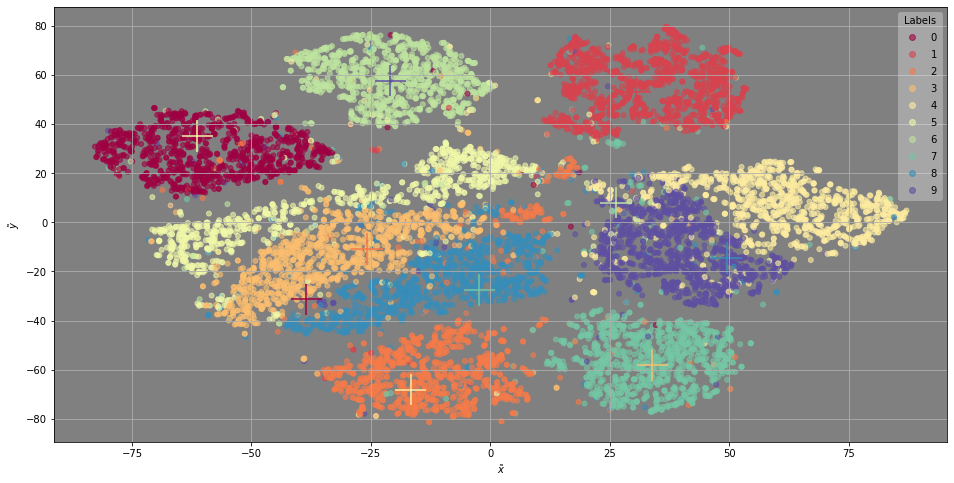

In [15]:
encoder.set_weights(encoder_ft_param)
z = encoder(x_train).numpy()

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    a = z
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))

        a = np.concatenate((z, centroids), axis=0)
    X_feature_embedded = TSNE(n_components=2,
                              n_jobs=-1,
                              random_state=51550).fit_transform(a)
    fig, ax = plt.subplots(figsize=(16, 8))
    scatter = plt.scatter(X_feature_embedded[:len(x_test), 0],
                          X_feature_embedded[:len(x_test), 1],
                          c=labels,
                          s=[25]*len(x_test),
                          cmap='Spectral',
                          alpha=0.6)
    if centroids is not None:
        scatter1 = plt.scatter(X_feature_embedded[len(x_test):, 0],
                               X_feature_embedded[len(x_test):, 1],
                               c=range(n_clusters_found),
                               marker='+',
                               cmap='Spectral',
                               s=[1000]*n_clusters_found)
        ax.set_facecolor('gray')
    plt.grid()
    legend = ax.legend(*scatter.legend_elements(),
                       title="Labels", framealpha=0.3)
    plt.xlabel(r'$\tilde{x}$')
    plt.ylabel(r'$\tilde{y}$')
    plt.savefig(results_path/'cluster_tsne_space_{}.png'.format(desc))
    plt.show()
    #plt.close()
    del X_feature_embedded, a

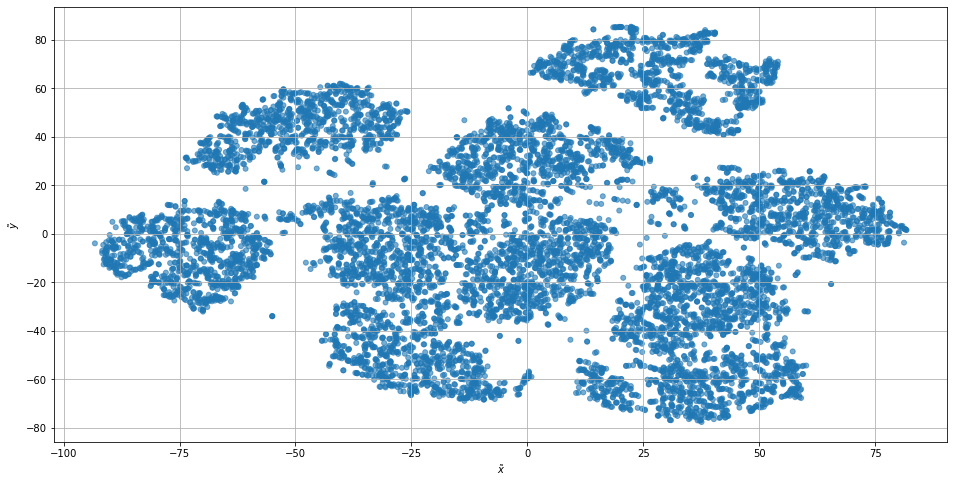

In [21]:
encoder.set_weights(encoder_param)
a = encoder(x_test).numpy()
X_feature_embedded = TSNE(n_components=2, random_state=51550).fit_transform(a)
fig, ax = plt.subplots(figsize=(16, 8))
scatter = plt.scatter(X_feature_embedded[:len(x_test), 0],
                      X_feature_embedded[:len(x_test), 1],
                      s=[25]*len(x_test),
                      alpha=0.6)
plt.grid()
#ax.set_facecolor('gray')
plt.xlabel(r'$\tilde{x}$')
plt.ylabel(r'$\tilde{y}$')
plt.savefig(results_path/'pretrain_tsne_space.png')
#plt.close()
del X_feature_embedded, a

In [ ]:
encoder.set_weights(encoder_final_param)
z = encoder(x_train).numpy()

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    a = z
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))

        a = np.concatenate((z, centroids), axis=0)
    fig, axs = plt.subplots(dims[-1], dims[-1],
                            figsize=(8*dims[-1], 4*dims[-1]),
                            squeeze=False,
                            facecolor='white',
                            dpi=200)
    for i in range(dims[-1]):
        for j in range(dims[-1]):
            ax = axs[i, j]
            scatter = ax.scatter(a[:len(x_train), i],
                                a[:len(x_train), j],
                                c=labels,
                                s=[25]*len(x_train),
                                cmap='Spectral',
                                alpha=0.6)
            if centroids is not None:
                scatter1 = ax.scatter(a[len(x_train):, i],
                                    a[len(x_train):, j],
                                    c=range(n_clusters_found),
                                    marker='+',
                                    s=[1000]*n_clusters_found,
                                    cmap='Spectral')
                ax.set_facecolor('gray')
            ax.grid()
            legend = ax.legend(*scatter.legend_elements(),
                            title="Labels",
                            framealpha=0.3,
                            prop={'size': 6})
            ax.set_xlabel(r'$\tilde{x}_{%d}$' % i)
            ax.set_ylabel(r'$\tilde{x}_{%d}$' % j)
    plt.savefig(results_path/'cluster_feature_space_{}.png'.format(desc),
                facecolor=fig.get_facecolor(),
                edgecolor='none')
    plt.close()
del a

In [16]:
encoder.set_weights(encoder_ft_param)
z = encoder(x_train).numpy()

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    a = z
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))

        a = np.concatenate((z, centroids), axis=0)
    fig, axs = plt.subplots(dims[-1], dims[-1],
                            figsize=(8*dims[-1], 4*dims[-1]),
                            squeeze=False,
                            facecolor='white',
                            dpi=200)
    for i in range(dims[-1]):
        for j in range(dims[-1]):
            ax = axs[i, j]
            scatter = ax.scatter(a[:len(x_test), i],
                                 a[:len(x_test), j],
                                 c=labels,
                                 s=[25]*len(x_test),
                                 cmap='Spectral',
                                 alpha=0.6)
            if centroids is not None:
                scatter1 = ax.scatter(a[len(x_test):, i],
                                      a[len(x_test):, j],
                                      c=range(n_clusters_found),
                                      marker='+',
                                      cmap='Spectral',
                                      s=[1000]*n_clusters_found)
                ax.set_facecolor('gray')
            ax.grid()
            legend = ax.legend(*scatter.legend_elements(),
                               title="Labels",
                               framealpha=0.3,
                               prop={'size': 6})
            ax.set_xlabel(r'$\tilde{x}_{%d}$' % i)
            ax.set_ylabel(r'$\tilde{x}_{%d}$' % j)
    plt.savefig(results_path/'finetune_feature_space_{}.png'.format(desc),
                facecolor=fig.get_facecolor(),
                edgecolor='none')
    plt.close()
del a


In [ ]:
encoder.set_weights(encoder_param)
a = encoder(x_test).numpy()
fig, axs = plt.subplots(dims[-1], dims[-1],
                        figsize=(8*dims[-1], 4*dims[-1]),
                        squeeze=False,
                        facecolor='white',
                        dpi=200)
for i in range(dims[-1]):
    for j in range(dims[-1]):
        ax = axs[i, j]
        scatter = ax.scatter(a[:len(x_test), i],
                            a[:len(x_test), j],
                            s=[25]*len(x_test),
                            alpha=0.6)
        ax.grid()
        ax.set_xlabel(r'$\tilde{x}_{%d}$' % i)
        ax.set_ylabel(r'$\tilde{x}_{%d}$' % j)
plt.savefig(results_path/'pretrain_feature_space.png',
            facecolor=fig.get_facecolor(),
            edgecolor='none')
plt.close()
del a

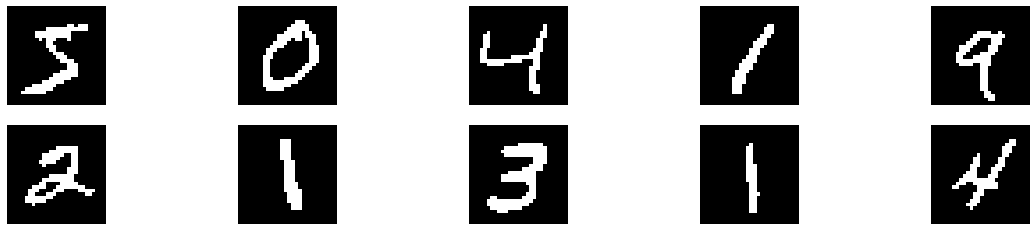

In [17]:
## Example BMNIST digits
figure = plt.figure(figsize=(20, 4))
j = 0

for example in x_train[:10]:
  plt.subplot(2, 5, j+1)
  plt.imshow(example.reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

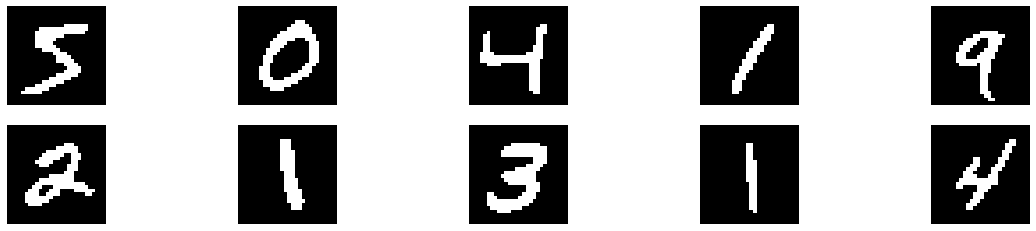

In [18]:
## Example BMNIST digits from pretrained autoencoder
encoder.set_weights(encoder_param['arr_0'])
figure = plt.figure(figsize=(20, 4))
j = 0

for example in autoencoder(x_train[:10]):
  plt.subplot(2, 5, j+1)
  plt.imshow(np.round(example).reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

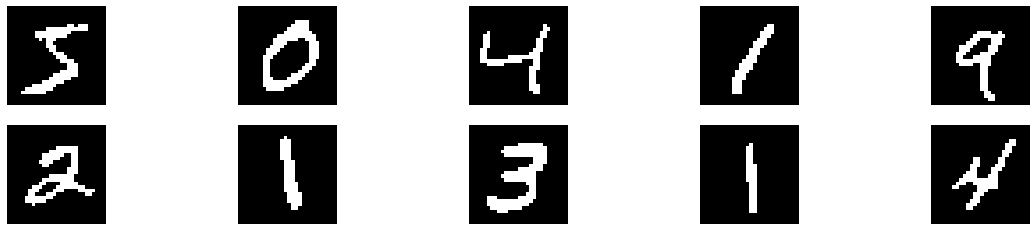

In [19]:
## Example BMNIST digits from finetuned autoencoder
encoder.set_weights(encoder_ft_param['arr_0'])
figure = plt.figure(figsize=(20, 4))
j = 0

for example in autoencoder(x_train[:10]):
  plt.subplot(2, 5, j+1)
  plt.imshow(np.round(example).reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

In [20]:
## Example BMNIST digits from final model
encoder.set_weights(encoder_final_param)
figure = plt.figure(figsize=(20, 4))
j = 0

for example in autoencoder(x_train[:10]).numpy():
  plt.subplot(2, 5, j+1)
  plt.imshow(example.reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

ValueError: Layer weight shape (784, 500) not compatible with provided weight shape (784, 522)